# Introduction
The CIFAR-10 dataset consists of 60,000 images. Each image has 32*32 pixels and 3 colour channels. There are 10 classes, 6000 images per class. There are 50000 training images and 10000 test images. The goal of this project is to use convolutional neural networks to predict the labels of previously unseen images. I use VGG-3 as the baseline with some regularization, dropout and batch normalization.

# Step 1- Import Necessary Libraries

In [1]:
#Importing libraries

from tensorflow import keras
import os
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

/home/ujala/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Step 2- Importing and Loading the Dataset

In [3]:
#importing data
from keras.datasets import cifar10

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del x, y
   del x_test, y_test
   print('Clear previously loaded data.')
except:
   pass

#load data
(x, y),(x_test, y_test) = cifar10.load_data()



# As a sanity check, print out the size of the training and test data.
print('Training data shape: ', x.shape)
print('Training labels shape: ', y.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Using TensorFlow backend.


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


# Step 3- Data Visualization

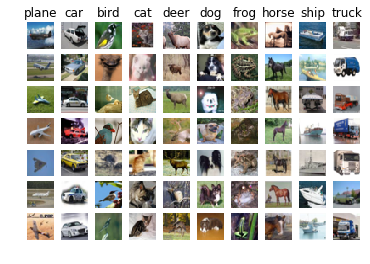

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for i, cls in enumerate(classes):
    idxs = np.flatnonzero(y == i)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for j, idx in enumerate(idxs):
        plt_idx = j * num_classes + i + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x[idx].astype('uint8'))
        plt.axis('off')
        if j == 0:
            plt.title(cls)
plt.show()

# Step 4- Splitting Data into Train, Validation and Test sets

In [5]:
#Splitting x,y data into train and validation data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape)
print(x_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


# Step 5- Data Preprocessing (rescaling, vectorization and augmentation)

In [6]:
#Data Preprocessing

#Rescaling image pixels
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

#One Hot Encoding of Categorical labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#Data Augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train,y_train, batch_size = 64)

# Step 6- Defining the Model (Architecture and Compilation)

In [7]:
#Model Definition
def model_cifar10():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = optimizers.RMSprop(learning_rate=0.001,epsilon=1e-6)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = model_cifar10()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

# Step 7- Monitoring model performance using Tensorboard and Callbacks

In [8]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


# Step 8- Model Fitting

In [9]:
#Fit the model 

steps = int(x_train.shape[0]/64)
history = model.fit_generator(train_generator, steps_per_epoch = steps, epochs = 120, validation_data = (x_val, y_val), callbacks=[tensorboard_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 625 steps, validate on 10000 samples
Epoch 1/120
625/625 [==============================] - 312s 499ms/step - loss: 1.5410 - accuracy: 0.4584 - val_loss: 1.1667 - val_accuracy: 0.5990
Epoch 2/120
625/625 [==============================] - 307s 491ms/step - loss: 1.0423 - accuracy: 0.6324 - val_loss: 1.0646 - val_accuracy: 0.6488
Epoch 3/120
625/625 [==============================] - 301s 481ms/step - loss: 0.8773 - accuracy: 0.6926 - val_loss: 0.8120 - val_accuracy: 0.7207
Epoch 4/120
625/625 [==============================] - 298s 477ms/step - loss: 0.7878 - accuracy: 0.7261 - val_loss: 0.7740 - val_accuracy: 0.7390
Epoch 5/120
625/625 [==============================] - 297s 475ms/step - loss: 0.7209 - accuracy: 0.7499 - val_loss: 0.6713 - val_accuracy: 0.7676
Epoch 6/120
625/625 [==============================] - 294s 471ms/step - loss: 0.6721 - accuracy: 0.7678 - val_loss: 

Epoch 54/120
625/625 [==============================] - 313s 500ms/step - loss: 0.2800 - accuracy: 0.9037 - val_loss: 0.4285 - val_accuracy: 0.8691
Epoch 55/120
625/625 [==============================] - 315s 504ms/step - loss: 0.2933 - accuracy: 0.9002 - val_loss: 0.4067 - val_accuracy: 0.8743
Epoch 56/120
625/625 [==============================] - 314s 503ms/step - loss: 0.2863 - accuracy: 0.9010 - val_loss: 0.4023 - val_accuracy: 0.8818
Epoch 57/120
625/625 [==============================] - 312s 500ms/step - loss: 0.2769 - accuracy: 0.9044 - val_loss: 0.4361 - val_accuracy: 0.8734
Epoch 58/120
625/625 [==============================] - 308s 492ms/step - loss: 0.2825 - accuracy: 0.9032 - val_loss: 0.4597 - val_accuracy: 0.8578
Epoch 59/120
625/625 [==============================] - 304s 487ms/step - loss: 0.2743 - accuracy: 0.9053 - val_loss: 0.4842 - val_accuracy: 0.8636
Epoch 60/120
625/625 [==============================] - 304s 487ms/step - loss: 0.2727 - accuracy: 0.9055 - val_

625/625 [==============================] - 303s 485ms/step - loss: 0.2166 - accuracy: 0.9272 - val_loss: 0.3954 - val_accuracy: 0.8825
Epoch 110/120
625/625 [==============================] - 307s 492ms/step - loss: 0.2147 - accuracy: 0.9255 - val_loss: 0.4161 - val_accuracy: 0.8788
Epoch 111/120
625/625 [==============================] - 307s 490ms/step - loss: 0.2155 - accuracy: 0.9246 - val_loss: 0.3928 - val_accuracy: 0.8829
Epoch 112/120
625/625 [==============================] - 314s 503ms/step - loss: 0.2134 - accuracy: 0.9248 - val_loss: 0.4040 - val_accuracy: 0.8808
Epoch 113/120
625/625 [==============================] - 315s 504ms/step - loss: 0.2125 - accuracy: 0.9265 - val_loss: 0.3645 - val_accuracy: 0.8876
Epoch 114/120
625/625 [==============================] - 311s 497ms/step - loss: 0.2166 - accuracy: 0.9240 - val_loss: 0.4070 - val_accuracy: 0.8824
Epoch 115/120
625/625 [==============================] - 305s 489ms/step - loss: 0.2126 - accuracy: 0.9266 - val_loss: 0

# Step 9- Plotting Results (loss and accuracy)

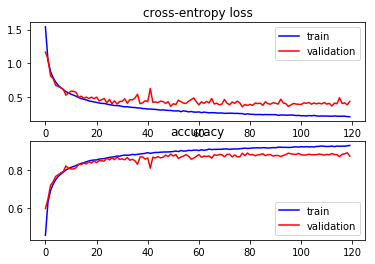

In [10]:
#Visualizing model performance

#Plot loss
plt.subplot(211)
plt.title('cross-entropy loss')
plt.plot(history.history['loss'],color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation')
plt.legend()

  #plot accurcay
plt.subplot(212)
plt.title('accuracy')
plt.plot(history.history['accuracy'],color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'validation')
plt.legend()


# Step 10- Evaluating Model Performance on the Test data

In [11]:
#Model Evaluation
results = model.evaluate(x_test, y_test)
print(results)

10000/10000 [==============================] - 17s 2ms/sample - loss: 0.4459 - accuracy: 0.8778
[0.4458612423658371, 0.8778]
